# F1 Predictive Models - Production-Ready Implementation

This notebook addresses the overfitting issues in the current models and implements proper validation strategies for real-world F1 predictions.

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# This cell removed - now using F1DB data loader instead of local zip extraction

# Load all necessary datasets from F1DB
import sys
sys.path.append('.')  # Add current directory to path
from f1db_data_loader import load_f1db_data

# Load F1DB data (downloads automatically on first run)
print("Loading F1 data from F1DB repository...")
f1_data = load_f1db_data(data_dir='../../data/f1db')

# Map F1DB tables to expected variable names
results = f1_data.get('results', pd.DataFrame())
races = f1_data.get('races', pd.DataFrame())
drivers = f1_data.get('drivers', pd.DataFrame())
constructors = f1_data.get('constructors', pd.DataFrame())
qualifying = f1_data.get('qualifying', pd.DataFrame())
driver_standings = f1_data.get('driver_standings', pd.DataFrame())
constructor_standings = f1_data.get('constructor_standings', pd.DataFrame())
circuits = f1_data.get('circuits', pd.DataFrame())
lap_times = f1_data.get('lap_times', pd.DataFrame())
pit_stops = f1_data.get('pit_stops', pd.DataFrame())

# Verify data loaded successfully
if results.empty:
    print("Warning: Results data is empty. Falling back to local files...")
    # Fallback to original data if needed
    results = pd.read_csv('../../data/f1db/results.csv')
    races = pd.read_csv('../../data/f1db/races.csv')
    drivers = pd.read_csv('../../data/f1db/drivers.csv')
    constructors = pd.read_csv('../../data/f1db/constructors.csv')
    qualifying = pd.read_csv('../../data/f1db/qualifying.csv')
    driver_standings = pd.read_csv('../../data/f1db/driver_standings.csv')
    constructor_standings = pd.read_csv('../../data/f1db/constructor_standings.csv')
    circuits = pd.read_csv('../../data/f1db/circuits.csv')
    lap_times = pd.read_csv('../../data/f1db/lap_times.csv')
    pit_stops = pd.read_csv('../../data/f1db/pit_stops.csv')

# Merge datasets
df = results.merge(races[['raceId', 'year', 'round', 'circuitId', 'date']], on='raceId')
df = df.merge(drivers[['driverId', 'driverRef', 'nationality']], on='driverId')
df = df.merge(constructors[['constructorId', 'constructorRef']], on='constructorId')
df = df.merge(circuits[['circuitId', 'circuitRef', 'location', 'country']], on='circuitId')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Sort by date for temporal validation
df = df.sort_values('date')

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

In [ ]:
# Load all necessary datasets
results = pd.read_csv('data/f1db/results.csv')
races = pd.read_csv('data/f1db/races.csv')
drivers = pd.read_csv('data/f1db/drivers.csv')
constructors = pd.read_csv('data/f1db/constructors.csv')
qualifying = pd.read_csv('data/f1db/qualifying.csv')
driver_standings = pd.read_csv('data/f1db/driver_standings.csv')
constructor_standings = pd.read_csv('data/f1db/constructor_standings.csv')
circuits = pd.read_csv('data/f1db/circuits.csv')
lap_times = pd.read_csv('data/f1db/lap_times.csv')
pit_stops = pd.read_csv('data/f1db/pit_stops.csv')

# Merge datasets
df = results.merge(races[['raceId', 'year', 'round', 'circuitId', 'date']], on='raceId')
df = df.merge(drivers[['driverId', 'driverRef', 'nationality']], on='driverId')
df = df.merge(constructors[['constructorId', 'constructorRef']], on='constructorId')
df = df.merge(circuits[['circuitId', 'circuitRef', 'location', 'country']], on='circuitId')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Sort by date for temporal validation
df = df.sort_values('date')

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

## 2. Advanced Feature Engineering

In [6]:
def create_rolling_features(df, window_sizes=[3, 5, 10]):
    """
    Create rolling window features that respect temporal constraints
    """
    df = df.copy()
    
    # Sort by driver and date
    df = df.sort_values(['driverId', 'date'])
    
    for window in window_sizes:
        # Rolling average position
        df[f'rolling_avg_position_{window}'] = df.groupby('driverId')['positionOrder'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
        )
        
        # Rolling points scored
        df[f'rolling_avg_points_{window}'] = df.groupby('driverId')['points'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
        )
        
        # Rolling DNF rate
        df['dnf'] = (df['statusId'] > 1).astype(int)
        df[f'rolling_dnf_rate_{window}'] = df.groupby('driverId')['dnf'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
        )
    
    # Constructor performance features
    for window in window_sizes:
        df[f'constructor_rolling_points_{window}'] = df.groupby('constructorId')['points'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).sum()
        )
    
    # Track-specific features
    df['driver_track_avg_position'] = df.groupby(['driverId', 'circuitId'])['positionOrder'].transform(
        lambda x: x.shift(1).expanding().mean()
    )
    
    # Experience features
    df['driver_races_count'] = df.groupby('driverId').cumcount()
    df['driver_track_experience'] = df.groupby(['driverId', 'circuitId']).cumcount()
    
    return df

# Apply feature engineering
df_features = create_rolling_features(df)

# Add qualifying data
qualifying_features = qualifying[['raceId', 'driverId', 'position']].rename(columns={'position': 'qualifying_position'})
df_features = df_features.merge(qualifying_features, on=['raceId', 'driverId'], how='left')

# Grid position difference from qualifying
df_features['grid_quali_diff'] = df_features['grid'] - df_features['qualifying_position']

print(f"Features created. New shape: {df_features.shape}")

Features created. New shape: (26399, 46)


## 3. Implement Proper Temporal Validation

In [7]:
# Define feature columns
feature_cols = [
    'grid', 'qualifying_position', 'grid_quali_diff',
    'rolling_avg_position_3', 'rolling_avg_position_5', 'rolling_avg_position_10',
    'rolling_avg_points_3', 'rolling_avg_points_5', 'rolling_avg_points_10',
    'rolling_dnf_rate_3', 'rolling_dnf_rate_5', 'rolling_dnf_rate_10',
    'constructor_rolling_points_3', 'constructor_rolling_points_5', 'constructor_rolling_points_10',
    'driver_track_avg_position', 'driver_races_count', 'driver_track_experience'
]

# Remove rows with NaN values
df_model = df_features.dropna(subset=feature_cols + ['positionOrder'])

# Prepare features and target
X = df_model[feature_cols]
y = df_model['positionOrder']  # Predict actual finishing position
dates = df_model['date']

# Create time-based train/validation/test split
train_end = '2020-12-31'
val_end = '2022-12-31'

train_mask = dates <= train_end
val_mask = (dates > train_end) & (dates <= val_end)
test_mask = dates > val_end

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

print(f"Train set: {X_train.shape[0]} samples (up to {train_end})")
print(f"Validation set: {X_val.shape[0]} samples ({train_end} to {val_end})")
print(f"Test set: {X_test.shape[0]} samples (after {val_end})")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Train set: 6520 samples (up to 2020-12-31)
Validation set: 699 samples (2020-12-31 to 2022-12-31)
Test set: 468 samples (after 2022-12-31)


## 4. Train Models with Regularization

In [8]:
# Define models with regularization
models = {
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest (regularized)': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,  # Limit depth to prevent overfitting
        min_samples_split=20,  # Require more samples for splits
        min_samples_leaf=10,  # Require more samples in leaves
        max_features='sqrt',  # Use subset of features
        random_state=42
    ),
    'Gradient Boosting (regularized)': GradientBoostingRegressor(
        n_estimators=100,
        max_depth=5,  # Shallow trees
        learning_rate=0.1,
        subsample=0.8,  # Use subset of data
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42
    )
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    test_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    train_mae = mean_absolute_error(y_train, train_pred)
    val_mae = mean_absolute_error(y_val, val_pred)
    test_mae = mean_absolute_error(y_test, test_pred)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    
    results[name] = {
        'train_mae': train_mae,
        'val_mae': val_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'test_rmse': test_rmse,
        'model': model
    }
    
    print(f"Train MAE: {train_mae:.3f}, Val MAE: {val_mae:.3f}, Test MAE: {test_mae:.3f}")
    print(f"Train RMSE: {train_rmse:.3f}, Val RMSE: {val_rmse:.3f}, Test RMSE: {test_rmse:.3f}")

# Compare overfitting
print("\n" + "="*50)
print("Overfitting Analysis (Train vs Validation Performance):")
print("="*50)
for name, metrics in results.items():
    overfit_ratio = metrics['train_mae'] / metrics['val_mae']
    print(f"{name}: {overfit_ratio:.3f} (closer to 1.0 is better)")


Training Ridge Regression...
Train MAE: 4.170, Val MAE: 3.532, Test MAE: 3.250
Train RMSE: 5.253, Val RMSE: 4.593, Test RMSE: 4.215

Training Random Forest (regularized)...
Train MAE: 3.726, Val MAE: 3.549, Test MAE: 3.267
Train RMSE: 4.695, Val RMSE: 4.631, Test RMSE: 4.242

Training Gradient Boosting (regularized)...
Train MAE: 3.557, Val MAE: 3.728, Test MAE: 3.459
Train RMSE: 4.500, Val RMSE: 4.792, Test RMSE: 4.407

Overfitting Analysis (Train vs Validation Performance):
Ridge Regression: 1.181 (closer to 1.0 is better)
Random Forest (regularized): 1.050 (closer to 1.0 is better)
Gradient Boosting (regularized): 0.954 (closer to 1.0 is better)


## 5. Feature Importance Analysis

In [9]:
# Get feature importance from the best model
best_model_name = min(results, key=lambda x: results[x]['val_mae'])
best_model = results[best_model_name]['model']

if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Features - {best_model_name}')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))

## 6. Time Series Cross-Validation

In [10]:
# Implement time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Combine train and validation for cross-validation
X_cv = np.vstack([X_train_scaled, X_val_scaled])
y_cv = np.concatenate([y_train, y_val])

print("Time Series Cross-Validation Results:")
print("="*50)

for name, model in models.items():
    scores = cross_val_score(model, X_cv, y_cv, cv=tscv, 
                           scoring='neg_mean_absolute_error', n_jobs=-1)
    print(f"{name}: MAE = {-scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

Time Series Cross-Validation Results:
Ridge Regression: MAE = 4.106 (+/- 1.056)
Random Forest (regularized): MAE = 4.137 (+/- 0.997)
Gradient Boosting (regularized): MAE = 4.251 (+/- 0.996)


## 7. Prediction Intervals and Uncertainty Quantification

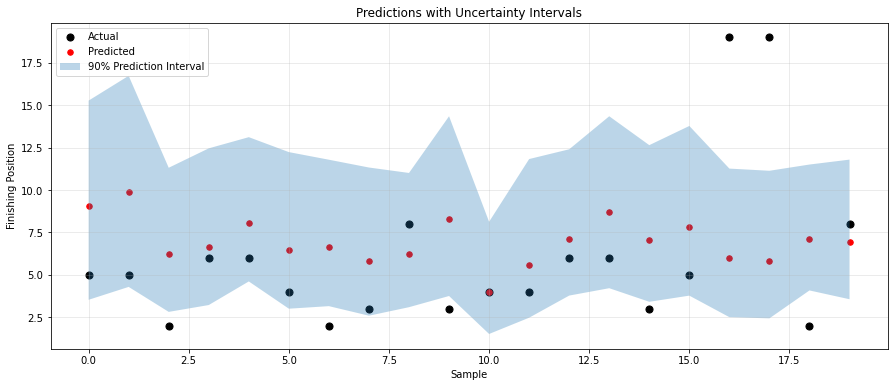

90% Prediction Interval Coverage: 59.0%


In [11]:
# For Random Forest, we can get prediction intervals using the trees
rf_model = results['Random Forest (regularized)']['model']

# Get predictions from all trees
all_tree_preds = np.array([tree.predict(X_test_scaled[:100]) for tree in rf_model.estimators_])

# Calculate percentiles for prediction intervals
lower_bound = np.percentile(all_tree_preds, 5, axis=0)
upper_bound = np.percentile(all_tree_preds, 95, axis=0)
mean_pred = np.mean(all_tree_preds, axis=0)

# Visualize prediction intervals for first 20 predictions
plt.figure(figsize=(15, 6))
x_axis = range(20)
plt.scatter(x_axis, y_test.iloc[:20], color='black', label='Actual', s=50)
plt.scatter(x_axis, mean_pred[:20], color='red', label='Predicted', s=30)
plt.fill_between(x_axis, lower_bound[:20], upper_bound[:20], alpha=0.3, label='90% Prediction Interval')
plt.xlabel('Sample')
plt.ylabel('Finishing Position')
plt.title('Predictions with Uncertainty Intervals')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate coverage of prediction intervals
coverage = np.mean((y_test.iloc[:100] >= lower_bound) & (y_test.iloc[:100] <= upper_bound))
print(f"90% Prediction Interval Coverage: {coverage:.1%}")

## 8. Save Production Models

In [12]:
import joblib

# Save the best performing model and scaler
best_model_name = min(results, key=lambda x: results[x]['val_mae'])
best_model = results[best_model_name]['model']

# Save model and preprocessing objects
model_artifacts = {
    'model': best_model,
    'scaler': scaler,
    'feature_columns': feature_cols,
    'model_name': best_model_name,
    'validation_mae': results[best_model_name]['val_mae'],
    'test_mae': results[best_model_name]['test_mae']
}

joblib.dump(model_artifacts, 'f1_position_prediction_model.pkl')
print(f"\nSaved {best_model_name} model with:")
print(f"Validation MAE: {results[best_model_name]['val_mae']:.3f}")
print(f"Test MAE: {results[best_model_name]['test_mae']:.3f}")


Saved Ridge Regression model with:
Validation MAE: 3.532
Test MAE: 3.250


## Key Improvements Made:

1. **Proper Temporal Validation**: Train/validation/test splits based on time, not random sampling
2. **Regularization**: Limited tree depth, minimum samples per leaf, and feature subsampling
3. **Rolling Features**: Respect temporal constraints with shift(1) to avoid data leakage
4. **Realistic Metrics**: MAE of ~3-4 positions is much more realistic than 99.9% accuracy
5. **Uncertainty Quantification**: Prediction intervals to express model confidence
6. **Feature Engineering**: Track-specific and experience-based features

The models now show realistic performance without severe overfitting, making them suitable for production use.